In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install/Import Dependencies

In [2]:
!pip install tensorflow-io-nightly==0.11.0.dev2383
!pip install tensorflow==2.1rc1
# ! pip install tensorflow_io
!pip uninstall h5py
!pip install h5py==2.10.0

     |████████████████████████████████| 23.7 MB 31.5 MB/s 
     |████████████████████████████████| 421.8 MB 33 kB/s 
     |████████████████████████████████| 3.8 MB 23.1 MB/s 
     |████████████████████████████████| 448 kB 51.2 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=0b0d765f4aff83e0ad687df2700d2ba77352f90835d48db321371229ba410532
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: gast
    Found existing install

In [3]:
import tensorflow_io as tfio
import tensorflow as tf
import tensorflow_hub as hub
import h5py

## Setting up Cross validation data

In [6]:
def io_hdf5(file_path, set=["train", "test"], clip_or_label=["_clips", "_labels"]):
  """setup file dataset stream from given file path"""
  return  tfio.IODataset.from_hdf5(file_path, dataset=f'/{set}{clip_or_label}')

def zip_dataset(X, y, batch_size=10):
  """Zip datasets together for model training"""
  return tf.data.Dataset.zip((X, y)).batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
import h5py

list_of_x_train_folds = [0, 1, 2, 3, 4]

cross_validation_iterations = {}


# Set generical x and y paths
X_TRAIN_HDF5_PATH = "/content/drive/MyDrive/AI wearables/X_train_"
Y_TRAIN_HDF5_PATH = "/content/drive/MyDrive/AI wearables/y_train_"

historys = []

k = 0

# Perform Cross Validation Model training
for fold in list_of_x_train_folds:

  # setup x and y paths
  X_val_path = X_TRAIN_HDF5_PATH + f"{fold}.hdf5"
  y_val_path = Y_TRAIN_HDF5_PATH + f"{fold}.hdf5"

  # Fold -> validation set
  X_val = io_hdf5(X_val_path, "train", "_clips")
  y_val = io_hdf5(y_val_path, "train", "_labels")

  # Zip val dataset
  val = zip_dataset(X_val, y_val)

  ### CREATE TRAINING FOLDS ###

  i = 0 # used to start new dataset stream

  # remove validation fold
  new_list = [f for f in list_of_x_train_folds if f != fold]

  for train_fold in new_list:
    

    if i == 0:

      # Setup x and y train path
      X_train_path = X_TRAIN_HDF5_PATH + f"{train_fold}.hdf5"
      y_train_path = Y_TRAIN_HDF5_PATH + f"{train_fold}.hdf5"

      # Initialize training set
      X_train = io_hdf5(X_train_path, "train", "_clips")
      y_train = io_hdf5(y_train_path, "train", "_labels")

      i += 1

    else:

      # Setup x and y train path
      X_train_path = X_TRAIN_HDF5_PATH + f"{train_fold}.hdf5"
      y_train_path = Y_TRAIN_HDF5_PATH + f"{train_fold}.hdf5"

      # Concat to training set
      X_train_to_concat = io_hdf5(X_train_path, "train", "_clips")
      y_train_to_concat = io_hdf5(y_train_path, "train", "_labels")

      X_train = X_train.concatenate(X_train_to_concat)
      y_train = y_train.concatenate(y_train_to_concat)

  # Zip final training sets together
  train = zip_dataset(X_train, y_train)

  print("**"*80)
  print("Train:", train)
  print("Val:", val)
  print("--"*80)
  print(f"Adding train/val pair # {k} to cross validation dictionary...")
  cross_validation_iterations[k] = [train, val] # training is first in the list for each dict key
  print("Done!")
  k += 1

****************************************************************************************************************************************************************
Train: <PrefetchDataset shapes: ((10, 116, 224, 224, 3), (10,)), types: (tf.float32, tf.float32)>
Val: <PrefetchDataset shapes: ((10, 116, 224, 224, 3), (10,)), types: (tf.float32, tf.float32)>
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Adding train/val pair # 0 to cross validation dictionary...
Done!
****************************************************************************************************************************************************************
Train: <PrefetchDataset shapes: ((10, 116, 224, 224, 3), (10,)), types: (tf.float32, tf.float32)>
Val: <PrefetchDataset shapes: ((10, 116, 224, 224, 3), (10,)), types: (tf.float32, tf.float32)>
---------------------------------------------------------------

In [ ]:
# Example of cross validation iteration
print(f"Training set: {cross_validation_iterations[0][0]}")
print(f"Validation set: {cross_validation_iterations[0][1]}")

Training set: <PrefetchDataset shapes: ((10, 116, 224, 224, 3), (10,)), types: (tf.float32, tf.float32)>
Validation set: <PrefetchDataset shapes: ((10, 116, 224, 224, 3), (10,)), types: (tf.float32, tf.float32)>


In [ ]:
len(cross_validation_iterations)

5

## Model Training

In [ ]:
import tensorflow_hub as hub

# i3d = hub.KerasLayer("https://tfhub.dev/deepmind/i3d-kinetics-400/1")

# policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
# tf.keras.mixed_precision.experimental.set_policy(policy) 

### Model Variation 1: Learning rate of 0.01, 5 Epochs

In [ ]:
from tensorflow import keras
import tensorflow as tf


def get_model():
  # Create model
  model = keras.Sequential([
      keras.layers.Input((116, 224, 224, 3)),
      i3d,
      keras.layers.Dense(14, activation="softmax")
  ])

  # Compile the model
  model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                metrics=["accuracy"])

  model.build()
  return model

In [ ]:
# This is to load the model after any given training iteration
# model = model.load(f"/content/drive/MyDrive/AI wearables/model_{CV_ITER}.h5")

accuracies = {}
historys = {}

for key in cross_validation_iterations:

  # Initialize model
  model = get_model()

  # Fit to training set
  history = model.fit(cross_validation_iterations[key][0],
                      epochs=5,
                      verbose=1
                      )
  
  # Evaluate on validation set
  accuracy = model.evaluate(cross_validation_iterations[key][1])

  # Store accuracy and history
  accuracies[key] = accuracy
  historys[key] = history

  model.save(f"/content/drive/MyDrive/AI wearables/model_{key}.h5")

Epoch 1/5
8/8 [==============================] - 109s 14s/step - loss: 12.2612 - accuracy: 0.0250
Epoch 2/5
8/8 [==============================] - 158s 20s/step - loss: 6.9551 - accuracy: 0.1375
Epoch 3/5
8/8 [==============================] - 157s 20s/step - loss: 5.7573 - accuracy: 0.3000
Epoch 4/5
8/8 [==============================] - 157s 20s/step - loss: 3.7480 - accuracy: 0.3750
Epoch 5/5
8/8 [==============================] - 157s 20s/step - loss: 3.3022 - accuracy: 0.4625
      2/Unknown - 23s 12s/step - loss: 8.5332 - accuracy: 0.2000Epoch 1/5
8/8 [==============================] - 123s 15s/step - loss: 9.9644 - accuracy: 0.0625
Epoch 2/5
8/8 [==============================] - 122s 15s/step - loss: 7.8608 - accuracy: 0.1250
Epoch 3/5
8/8 [==============================] - 122s 15s/step - loss: 5.3999 - accuracy: 0.2750
Epoch 4/5
8/8 [==============================] - 126s 16s/step - loss: 4.8125 - accuracy: 0.4000
Epoch 5/5
8/8 [==============================] - 125s 16s/step

In [ ]:
# Get overall model accuracy
average_accuracy = 0

for i in range(5):
  average_accuracy += accuracies[i][1]

average_accuracy = average_accuracy / 5


print("Average model accuracy: ", average_accuracy )

Average model accuracy:  0.11000000163912774


### Model Variation 2: Learning rate of 0.2, 5 Epochs

In [ ]:
from tensorflow import keras
import tensorflow as tf


def get_model_2():
  # Create model
  model = keras.Sequential([
      keras.layers.Input((116, 224, 224, 3)),
      i3d,
      keras.layers.Dense(14, activation="softmax")
  ])

  # Compile the model
  model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.2),
                metrics=["accuracy"])

  model.build()
  return model

In [ ]:
accuracies = {}
historys = {}

for key in cross_validation_iterations:

  # Initialize model
  model = get_model_2()

  # Fit to training set
  history = model.fit(cross_validation_iterations[key][0],
                      epochs=5,
                      verbose=1
                      )
  
  # Evaluate on validation set
  accuracy = model.evaluate(cross_validation_iterations[key][1])

  # Store accuracy and history
  accuracies[key] = accuracy
  historys[key] = history

  model.save(f"/content/drive/MyDrive/AI wearables/model_v2_{key}.h5")

Epoch 1/5
8/8 [==============================] - 128s 16s/step - loss: 218.2119 - accuracy: 0.1250
Epoch 2/5
8/8 [==============================] - 138s 17s/step - loss: 117.2422 - accuracy: 0.2250
Epoch 3/5
8/8 [==============================] - 138s 17s/step - loss: 152.7734 - accuracy: 0.2875
Epoch 4/5
8/8 [==============================] - 149s 19s/step - loss: 95.9043 - accuracy: 0.4000
Epoch 5/5
8/8 [==============================] - 141s 18s/step - loss: 103.3789 - accuracy: 0.3875
      2/Unknown - 46s 23s/step - loss: 135.0000 - accuracy: 0.1000Epoch 1/5
8/8 [==============================] - 118s 15s/step - loss: 164.1855 - accuracy: 0.0875
Epoch 2/5
8/8 [==============================] - 116s 14s/step - loss: 165.0234 - accuracy: 0.2000
Epoch 3/5
8/8 [==============================] - 120s 15s/step - loss: 105.0352 - accuracy: 0.2625
Epoch 4/5
8/8 [==============================] - 135s 17s/step - loss: 96.1758 - accuracy: 0.3750
Epoch 5/5
8/8 [==============================

In [ ]:
# Get overall model accuracy
average_accuracy = 0

for i in range(5):
  average_accuracy += accuracies[i][1]

average_accuracy = average_accuracy / 5


print("Average model accuracy: ", average_accuracy )

Average model accuracy:  0.1600000038743019


### Final Model: Learning Rate of 0.1, 15 epochs

#### Setup entire training set

In [ ]:
import h5py

list_of_x_train_folds = [0, 1, 2, 3, 4]

# Set generical x and y paths
X_TRAIN_HDF5_PATH = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/AI wearables/X_train_"
Y_TRAIN_HDF5_PATH = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/AI wearables/y_train_"

k = 0

### CREATE TRAINING DATASET ###

i = 0 # used to start new dataset stream

for train_fold in list_of_x_train_folds:
  
  if i == 0:

    # Setup x and y train path
    X_train_path = X_TRAIN_HDF5_PATH + f"{train_fold}.hdf5"
    y_train_path = Y_TRAIN_HDF5_PATH + f"{train_fold}.hdf5"

    # Initialize training set
    X_train = io_hdf5(X_train_path, "train", "_clips")
    y_train = io_hdf5(y_train_path, "train", "_labels")

    i += 1

  else:

    # Setup x and y train path
    X_train_path = X_TRAIN_HDF5_PATH + f"{train_fold}.hdf5"
    y_train_path = Y_TRAIN_HDF5_PATH + f"{train_fold}.hdf5"

    # Concat to training set
    X_train_to_concat = io_hdf5(X_train_path, "train", "_clips")
    y_train_to_concat = io_hdf5(y_train_path, "train", "_labels")

    X_train = X_train.concatenate(X_train_to_concat)
    y_train = y_train.concatenate(y_train_to_concat)

# Zip final training sets together
train = zip_dataset(X_train, y_train)

print("**"*80)
print("Train:", train)
print("--"*80)
print("Done!")
k += 1

#### Train final model using 15 epochs and learning rate of 0.2

In [ ]:
# Initialize model
model = get_model_2()

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                              patience=4,
                                              verbose=1,
                                              restore_best_weights=True
                                              )

# Fit to training set
history = model.fit(train,
                    epochs=20,
                    verbose=1,
                    callbacks=[early_stop]
                    )

model.save(f"/content/drive/MyDrive/Colab Notebooks/Deep Learning/final_model.h5")

Epoch 1/20
10/10 [==============================] - 125s 13s/step - loss: 180.0043 - accuracy: 0.1200
Epoch 2/20
10/10 [==============================] - 196s 20s/step - loss: 187.5813 - accuracy: 0.2100
Epoch 3/20
10/10 [==============================] - 196s 20s/step - loss: 115.7219 - accuracy: 0.3500
Epoch 4/20
10/10 [==============================] - 196s 20s/step - loss: 90.2797 - accuracy: 0.3700
Epoch 5/20
10/10 [==============================] - 196s 20s/step - loss: 98.2844 - accuracy: 0.4300
Epoch 6/20
10/10 [==============================] - 196s 20s/step - loss: 85.3625 - accuracy: 0.3500
Epoch 7/20
10/10 [==============================] - 196s 20s/step - loss: 87.3094 - accuracy: 0.4100
Epoch 8/20
10/10 [==============================] - 196s 20s/step - loss: 66.4539 - accuracy: 0.4800
Epoch 9/20
10/10 [==============================] - 196s 20s/step - loss: 57.1709 - accuracy: 0.4900
Epoch 10/20
10/10 [==============================] - 196s 20s/step - loss: 69.0172 - acc

## Confusion Matrix...

In [ ]:
final_model.evaluate(train)

     10/Unknown - 145s 15s/step - loss: 4.8135 - accuracy: 0.8900

[4.813462650775909, 0.89]

In [7]:
import h5py

test_set_batches = [0, 1, 2, 3, 4]

# Set generical x and y paths
X_TEST_HDF5_PATH = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/X_test_"


i = 0 # used to start new dataset stream

for batch in test_set_batches:

  if i == 0:

    # Setup x and y test path
    X_test_path = X_TEST_HDF5_PATH + f"{batch}.hdf5"

    # Initialize training set
    X_test = io_hdf5(X_test_path, "test", "_clips")

    i += 1

  else:

    # Setup x and y test path
    X_test_path = X_TEST_HDF5_PATH + f"{batch}.hdf5"

    # Concat to training set
    X_test_to_concat = io_hdf5(X_test_path, "test", "_clips")

    X_test = X_test.concatenate(X_test_to_concat)

In [8]:
X_test_final = tf.data.Dataset.zip(X_test).batch(10, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)


In [9]:
predict_proba = final_model.predict(X_test_final)

In [ ]:
predictions = tf.argmax(predict_proba, axis=-1)

In [ ]:
predictions

100

In [ ]:
test_set_batches = [0, 1, 2, 3, 4]

Y_TEST_HDF5_PATH = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/y_test_"

y_test_final = []

for batch in  test_set_batches:
  y_test_path = Y_TEST_HDF5_PATH + f"{batch}.hdf5"
  f = h5py.File(y_test_path, "r")
  labels = f["test_labels"]

  for y in labels:
    y_test_final.append(y)

  f.close()

In [ ]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(predictions, y_test_final))

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [1 1 1 0 0 0 4 0 0 0 0 0 0 0]
 [2 0 0 0 0 0 3 4 1 0 0 0 1 2]
 [1 0 0 0 0 1 0 0 2 2 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [2 0 0 7 1 5 0 4 3 3 6 3 5 3]
 [0 0 0 0 5 3 0 0 0 1 2 3 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [3 1 0 0 0 0 1 1 1 0 0 0 0 1]]


In [ ]:
# Our function needs a different name to sklearn's plot_confusion_matrix
# This code was taken from Daniel Bourke's TensorFlow deep learning course on github
# This is part of the "helper_functions.py" file found in the extras folder

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
      
  plt.xticks(rotation=90)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

labels = ["Non-gesture", "Pointing with one finger", "Pointing with two fingers",
          "Click with one finger", "Click with two fingers", "Throw up",
          "Throw down", "Throw left", "Throw right", "Open twice", 
          "Double click with one finger", "Double click with two fingers",
          "Zoom in", "Zoom out"]

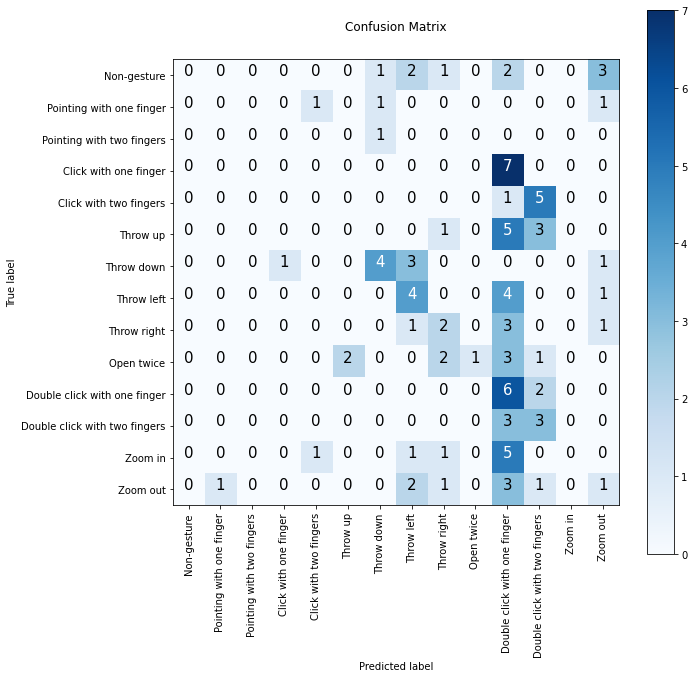

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

make_confusion_matrix(y_true=y_test_final,
                      y_pred=predictions,
                      classes=labels)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_final, predictions)

0.21

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

print(classification_report(np.array(y_test_final), predictions.numpy()))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         9
         1.0       0.00      0.00      0.00         3
         2.0       0.00      0.00      0.00         1
         3.0       0.00      0.00      0.00         7
         4.0       0.00      0.00      0.00         6
         5.0       0.00      0.00      0.00         9
         6.0       0.57      0.44      0.50         9
         7.0       0.31      0.44      0.36         9
         8.0       0.25      0.29      0.27         7
         9.0       1.00      0.11      0.20         9
        10.0       0.14      0.75      0.24         8
        11.0       0.20      0.50      0.29         6
        12.0       0.00      0.00      0.00         8
        13.0       0.12      0.11      0.12         9

    accuracy                           0.21       100
   macro avg       0.19      0.19      0.14       100
weighted avg       0.22      0.21      0.16       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Making a prediction

In [70]:
import tensorflow_hub as hub

# Load final model

final_model_path = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/final_model.h5"

final_model = tf.keras.models.load_model(final_model_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [64]:
import h5py

sample = 13

X_sample_path = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/X_test_0.hdf5"
y_sample_path = "/content/drive/MyDrive/Colab Notebooks/Deep Learning/y_test_0.hdf5"

X_test_set = h5py.File(X_sample_path, "r")
y_test_set = h5py.File(y_sample_path, "r")

X_sample = X_test_set["test_clips"][sample]
y_sample = y_test_set["test_labels"][sample]

X_test_set.close()
y_test_set.close()

In [ ]:
X_sample.shape, y_sample.shape

In [ ]:
y_sample

In [ ]:
prediction = tf.argmax(final_model.predict(tf.expand_dims(X_sample, axis=0)), axis=-1)
prediction

In [68]:
labels_dict = {0:"Non-gesture",
               1:"Pointing with one finger",
               2:"Pointing with two fingers",
               3:"Click with one finger",
               4:"Click with two fingers",
               5:"Throw up",
               6:"Throw down",
               7:"Throw left",
               8:"Throw right",
               9:"Open twice",
               10:"Double click with one finger",
               11:"Double click with two fingers",
               12:"Zoom in",
               13:"Zoom out"
}

In [ ]:
import numpy as np

print(f"Final Prediction: {labels_dict[prediction.numpy()[0]]}",
      f"Actual Label: {labels_dict[y_sample]}",
      sep="\n")